In [1]:
import os
import random
import numpy as np
from scipy.fft import dct

INPUT_DATA = "raw_p85.npz" # raw data as numpy object

In [3]:
# convert audio segments to features
stride = 2048
win_len = 4096
X, y = [], []

data = np.load(INPUT_DATA, allow_pickle=True)
for segment, label in zip(data["audio_segments"], data["labels"]):
    if len(segment) < win_len:
        frames = [np.pad(segment, (0, win_len - len(segment)), mode="constant")]
    else:
        # use dynamic stride for larger inputs
        dyn_stride = stride * (len(segment) // win_len)
        # create stride matrix from segment
        rows = (len(segment) - win_len) // dyn_stride + 1
        n_stride = segment.strides[0]
        frames = np.lib.stride_tricks.as_strided(segment, shape=(rows, win_len),
                                                 strides=(dyn_stride * n_stride, n_stride))
    for frame in frames:
        mdct = abs(dct(frame, type=4)[:win_len//2])
        mdct -= mdct.min()
        mdct /= mdct.max()
        preprocessing.normalize(mdct)
        X.append(mdct)
        y.append(label)
# convert features into numpy arrays for easier processing
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((78502, 2048), (78502,))

In [4]:
# split data into training (fine tuning) and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [6]:
import tensorflow as tf
import datetime

# limit gpu ram usage
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

now = datetime.datetime.now()
model_name = "upitch_" + now.strftime("%Y_%m_%d")

# define model architecture
inputs = tf.keras.Input(shape=(X.shape[-1]), name="mdct")
expand = tf.keras.layers.Reshape(target_shape=(-1, 1))(inputs)
split = tf.split(expand, [64, 64, 128, 256, 512, 1024], axis=1)
concat = tf.keras.layers.Concatenate(axis=1)([
  tf.keras.layers.Conv1D(filters=1, kernel_size=1, strides=1, use_bias=False, activation=None, data_format="channels_last", padding='valid')(split[0]),
  tf.keras.layers.Conv1D(filters=1, kernel_size=2, strides=2, use_bias=False, activation=None, data_format="channels_last", padding='valid')(split[1]),
  tf.keras.layers.Conv1D(filters=1, kernel_size=4, strides=4, use_bias=False, activation=None, data_format="channels_last", padding='valid')(split[2]),
  tf.keras.layers.Conv1D(filters=1, kernel_size=8, strides=8, use_bias=False, activation=None, data_format="channels_last", padding='valid')(split[3]),
  tf.keras.layers.Conv1D(filters=1, kernel_size=16, strides=16, use_bias=False, activation=None, data_format="channels_last", padding='valid')(split[4]),
  tf.keras.layers.Conv1D(filters=1, kernel_size=32, strides=32, use_bias=False, activation=None, data_format="channels_last", padding='valid')(split[5])])
flat = tf.keras.layers.Flatten()(concat)
dense = tf.keras.layers.Dense(96, use_bias=True, activation=tf.nn.relu6)(flat)
drop = tf.keras.layers.Dropout(0.3)(dense)
outputs = tf.keras.layers.Dense(12, use_bias=True, activation="softmax", name="pitches")(drop)
model = tf.keras.Model(inputs, outputs, name=model_name)

model.summary()

Model: "upitch_2020_12_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mdct (InputLayer)               [(None, 2048)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 2048, 1)      0           mdct[0][0]                       
__________________________________________________________________________________________________
tf.split (TFOpLambda)           [(None, 64, 1), (Non 0           reshape[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 64, 1)        1           tf.split[0][0]                   
__________________________________________________________________________________

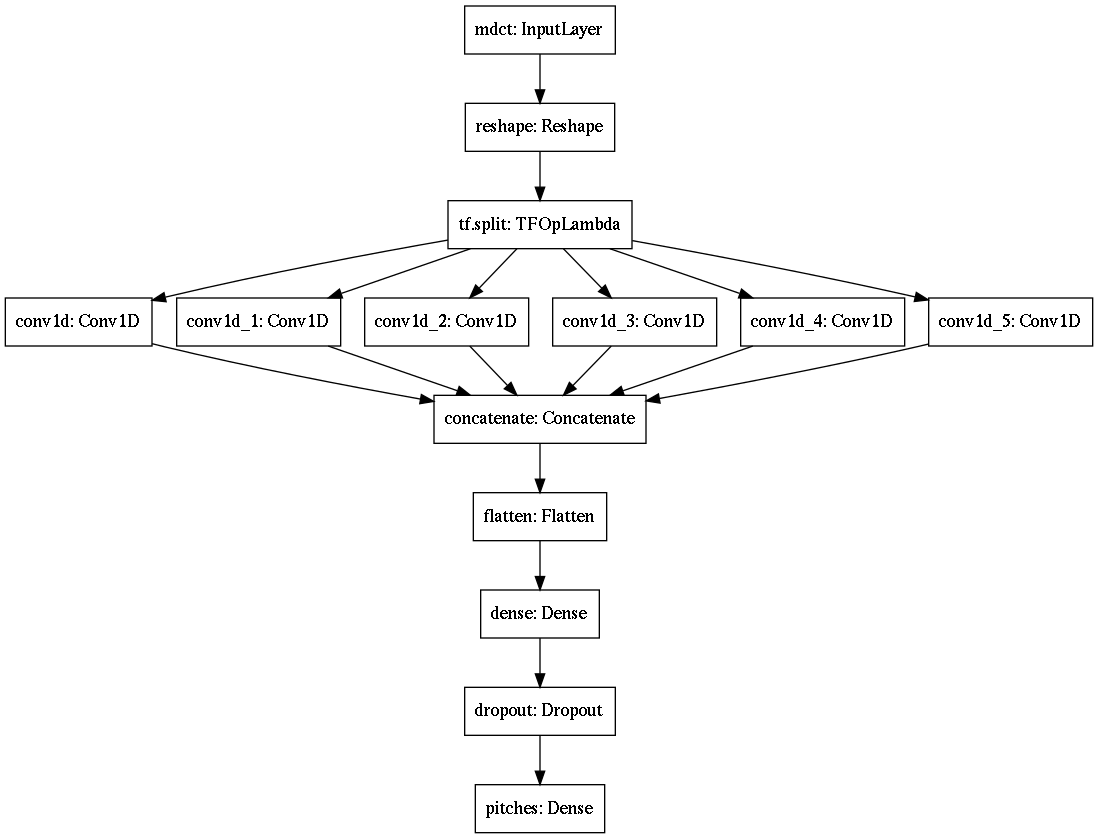

In [7]:
from tensorflow.keras.utils import plot_model

# plot model architecture as graph
plot_model(model, to_file='model.png')

In [8]:
from time import time

print("using tensorflow " + str(tf.__version__))
# init tensorboard for vizualization
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(time()))
# use adam optimizer with an initial learning rate of 0.001
opt = tf.keras.optimizers.Adam(lr=0.0010)
# use categorical_crossentropy as loss function while training
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the model with 30 iterations and a batch size of 32
EPOCHS, BATCH_SIZE = 30, 256
H = model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard])

using tensorflow 2.4.0
Epoch 1/30
221/221 [==============================] - 5s 13ms/step - loss: 2.2335 - accuracy: 0.2809 - val_loss: 0.7547 - val_accuracy: 0.8342
Epoch 2/30
221/221 [==============================] - 2s 8ms/step - loss: 0.7147 - accuracy: 0.8141 - val_loss: 0.5259 - val_accuracy: 0.8588
Epoch 3/30
221/221 [==============================] - 2s 8ms/step - loss: 0.5640 - accuracy: 0.8438 - val_loss: 0.4919 - val_accuracy: 0.8646
Epoch 4/30
221/221 [==============================] - 2s 8ms/step - loss: 0.5138 - accuracy: 0.8577 - val_loss: 0.4725 - val_accuracy: 0.8686
Epoch 5/30
221/221 [==============================] - 2s 8ms/step - loss: 0.4945 - accuracy: 0.8620 - val_loss: 0.4630 - val_accuracy: 0.8686
Epoch 6/30
221/221 [==============================] - 2s 8ms/step - loss: 0.4842 - accuracy: 0.8625 - val_loss: 0.4548 - val_accuracy: 0.8717
Epoch 7/30
221/221 [==============================] - 2s 8ms/step - loss: 0.4650 - accuracy: 0.8679 - val_loss: 0.4480 - val

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       592
           1       0.87      0.90      0.89       599
           2       0.87      0.92      0.90       760
           3       0.90      0.86      0.88       539
           4       0.89      0.90      0.90       996
           5       0.88      0.88      0.88       574
           6       0.90      0.87      0.89       754
           7       0.90      0.92      0.91       671
           8       0.85      0.88      0.86       488
           9       0.88      0.87      0.87       751
          10       0.88      0.85      0.86       491
          11       0.88      0.87      0.87       636

    accuracy                           0.88      7851
   macro avg       0.88      0.88      0.88      7851
weighted avg       0.88      0.88      0.88      7851

246/246 - 1s - loss: 0.4068 - accuracy: 0.8846

Test accuracy:  0.8846006989479065


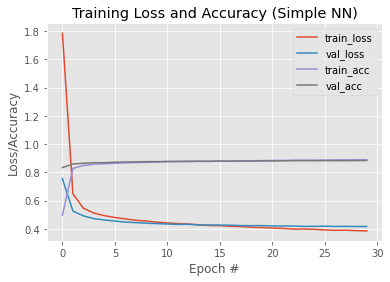

In [9]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# print individual and average accuracy
predictions = model.predict(X_test, batch_size=BATCH_SIZE)
print(classification_report(y_test, predictions.argmax(axis=1)))
_, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy: ", test_acc)
# plot the training/testing loss and accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [4]:
import onnx
import keras2onnx

model.save("tf_model")
onnx_model = keras2onnx.convert_keras(model, model.name, target_opset=12, channel_first_inputs=["mdct:0"], doc_string="model for relative pitch detection, requires a normalized dct type 4 as input")
shaped_onnx_model = onnx.shape_inference.infer_shapes(onnx_model)
keras2onnx.save_model(shaped_onnx_model, model_name + ".onnx")